# Multivariate linear regression 

In this notebook I fit an oridinary least squares (OLS) regression to predict the load and day ahead prices of electricity in Germany. The OLS prediction is a starting point will be used as a benchmark for comparison with forecasts made by more advanced machine learning models. 

Notes:

- In an attempt to make the problem more realistic, I made the assumption that data is accessible with a delay of 24 hours. We can not predict load nor prices with t-1 observations. The only contemporary variables are categorical variables for the hour of the day, the day of the week, ... 

- I simulated weather forecast by adding a random noise following a standard normal distribution to the actual weather data.

- Imports variables corresponds to the total amount of electricity imported to Germany for a specific hour. Imports comes from one of the following country: Netherlands, France, Austria, Poland, Czech repuclic.   

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels import regression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

## 2.1 Create useful functions 

In [2]:
#define a function to split the dataset between training and test 
def train_test_split(length, X, y, ratio):
    X_train = X.iloc[:int(length*ratio)]
    y_train = y.iloc[:int(length*ratio)]
    X_test = X.iloc[int(length*ratio):]
    y_test = y.iloc[int(length*ratio):]
    return X_train, y_train, X_test, y_test

In [3]:
def linreg(X,Y):
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit(cov_type='HC1')
    a = model.params[0]
    b = model.params[1]
    X = X[:, 1]

    return model.summary()

In [4]:
#def MAPE 
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
#define evaluation function 
def evaluation(y_true, y_pred):
    print("RMSE:", np.sqrt(mean_squared_error(y_pred, y_true)))
    print("MAPE:", mean_absolute_percentage_error(y_true, y_pred))

In [6]:
def model_prediction(func, X_train, y_train, X_test):
    y_pred = func.fit(X_train, y_train).predict(X_test)
    return y_pred

In [7]:
def plot_prediction(y_pred, y_test, xlabel, ylabel, title, png):
    plt.figure(0, figsize=(12,5))
    plt.plot(y_pred, '--', c='r', label='pred.', lw=2)
    plt.plot(y_test.values, c='black', label='actual', lw=2)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.title(title, fontsize=17)
    plt.legend(fontsize=13)
    plt.savefig(png)
    plt.show()

## 2.2  Load and prepare data 

In [8]:
#load dataset
df = pd.read_csv("C:/Users/julie/supervised_project/PS2021.csv", index_col='Unnamed: 0')
df.head()

,day_ahead_p,load,impFR,impNL,impCZ,impPL,impAT,temp_DE,temp_DE2,roll_std24,...,day,month,year,weekday,season,temp,HDD,CDD,sim_wthr_fcst,sim_wthr_fcst2
2015-01-04 23:00:00+00:00,22.34,49275.75,617.0,0.0,828.0,0.0,0.0,1.483241,2.200005,12.763541,...,4,1,2015,7,1,-16.516759,0,1,-0.340471,0.115920
2015-01-05 00:00:00+00:00,17.93,47116.50,676.0,0.0,807.0,0.0,0.0,1.451013,2.105438,12.763541,...,5,1,2015,1,1,-16.548987,0,1,0.260916,0.068077
2015-01-05 01:00:00+00:00,15.17,45836.75,788.0,0.0,808.0,0.0,0.0,1.409041,1.985395,12.763541,...,5,1,2015,1,1,-16.590959,0,1,0.729922,0.532786
2015-01-05 02:00:00+00:00,16.38,45674.00,986.0,0.0,807.0,0.0,0.0,1.317127,1.734824,12.763541,...,5,1,2015,1,1,-16.682873,0,1,2.782545,7.742554
2015-01-05 03:00:00+00:00,17.38,46536.75,996.0,0.0,828.0,0.0,0.0,1.178413,1.388658,12.763541,...,5,1,2015,1,1,-16.821587,0,1,1.856353,3.446046


In [9]:
#define X and y 
X = df[[
    'sim_wthr_fcst',
    'sim_wthr_fcst2',
    'weekday', 
    'hour', 
    'season', 
    'year',
    'impFR_lag24',
    'impNL_lag24',
    'impCZ_lag24',
    'impAT_lag24',
    'impPL_lag24',
    'load_lag24'
       ]]

X_price = df[[
    'sim_wthr_fcst',
    'sim_wthr_fcst2',
    'weekday',
    'hour',
    'season',
    'year',
    'impFR_lag24',
    'impNL_lag24',
    'impCZ_lag24',
    'impPL_lag24',
    'impAT_lag24',
    'day_ahead_p_lag24',
    'roll_std24_lag24']]

y = df['load']
    
y_price = df['day_ahead_p']

#Create training and test datasets 
X_train, y_train, X_test, y_test = train_test_split(len(df), X, y, 0.75)
X_train_price, y_train_price, X_test_price, y_test_price = train_test_split(len(df), X_price, y_price, 0.75)

## 2.3 Estimation

In [10]:
#Load estimation
ols = linreg(X_train.values, y_train.values)
ols

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                 1.433e+04
Date:                Fri, 19 Mar 2021   Prob (F-statistic):               0.00
Time:                        11:55:40   Log-Likelihood:            -2.2206e+05
No. Observations:               22337   AIC:                         4.441e+05
Df Residuals:                   22324   BIC:                         4.442e+05
Df Model:                          12                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.652e+05   1.08e+05     -4.323      0.000   -6.76e+05   -2.54e+05
x1          -213.1817     13.044    -16.343      0.000    -238.748    -187.616
x2             7.6703      0.493     15.559      0.000       6.704       8.636
x3         -2658.7733     19.458   -136.645      0.000   -2696.909   -2620.637
x4            60.1257      4.725     12.724      0.000      50.864      69.387
x5           -16.2018     39.682     -0.408      0.683     -93.978      61.574
x6           243.3498     53.368      4.560      0.000     138.750     347.949
x7            -0.1125      0.037     -3.078      0.002      -0.184      -0.041
x8            -1.1682      0.155     -7.538      0.000      -1.472      -0.864
x9            -0.8080      0.100     -8.068      0.000      -1.004      -0.612
x10           -1.1658      0.221     -5.276      0.000      -1.599      -0.733
x11           -4.8774      0.810     -6.021      0.000      -6.465      -3.290
x12            0.7824      0.003    249.789      0.000       0.776       0.789
==============================================================================
Omnibus:                      748.974   Durbin-Watson:                   0.151
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1109.518
Skew:                           0.336   Prob(JB):                    1.18e-241
Kurtosis:                       3.860   Cond. No.                     1.97e+08
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.97e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
#day ahead price estimation
ols_price = linreg(X_train_price.values, y_train_price.values[:])
ols_price

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     839.1
Date:                Fri, 19 Mar 2021   Prob (F-statistic):               0.00
Time:                        11:55:40   Log-Likelihood:                -81417.
No. Observations:               22337   AIC:                         1.629e+05
Df Residuals:                   22323   BIC:                         1.630e+05
Df Model:                          13                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -187.1955    212.819     -0.880      0.379    -604.313     229.922
x1            -0.6335      0.029    -22.099      0.000      -0.690      -0.577
x2             0.0200      0.001     19.346      0.000       0.018       0.022
x3            -2.1243      0.036    -58.911      0.000      -2.195      -2.054
x4             0.1337      0.009     15.389      0.000       0.117       0.151
x5             1.0617      0.076     13.996      0.000       0.913       1.210
x6             0.1023      0.106      0.969      0.332      -0.105       0.309
x7            -0.0001   6.23e-05     -1.720      0.085      -0.000    1.49e-05
x8         -7.299e-05      0.000     -0.318      0.750      -0.001       0.000
x9            -0.0014      0.000     -7.690      0.000      -0.002      -0.001
x10            0.0144      0.002      8.674      0.000       0.011       0.018
x11            0.0006      0.000      1.645      0.100      -0.000       0.001
x12            0.6184      0.011     56.935      0.000       0.597       0.640
x13            0.1388      0.029      4.829      0.000       0.082       0.195
==============================================================================
Omnibus:                     5887.794   Durbin-Watson:                   0.203
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           187470.606
Skew:                          -0.623   Prob(JB):                         0.00
Kurtosis:                      17.138   Cond. No.                     7.46e+06
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 7.46e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 2.4 Prediction 

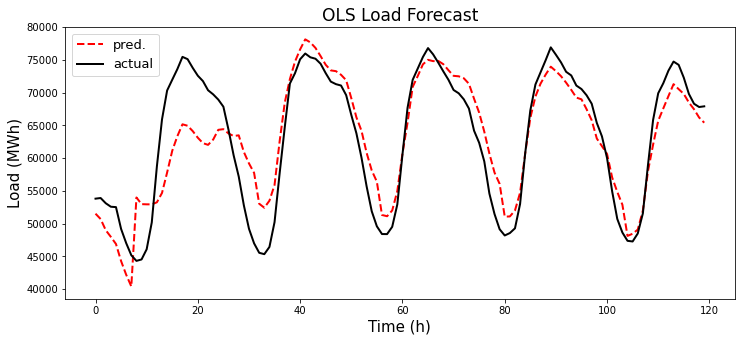

RMSE: 5127.116059896857
MAPE: 6.229373269452753


In [12]:
#Load prediction 
y_pred_ols = model_prediction(linear_model.LinearRegression(), 
                              X_train, 
                              y_train, 
                              X_test)

plot_prediction(y_pred_ols[:120], 
                y_test[:120], 
                "Time (h)", 
                "Load (MWh)", 
                "OLS Load Forecast", 
                "ols_pred.png")

evaluation(y_test, y_pred_ols)

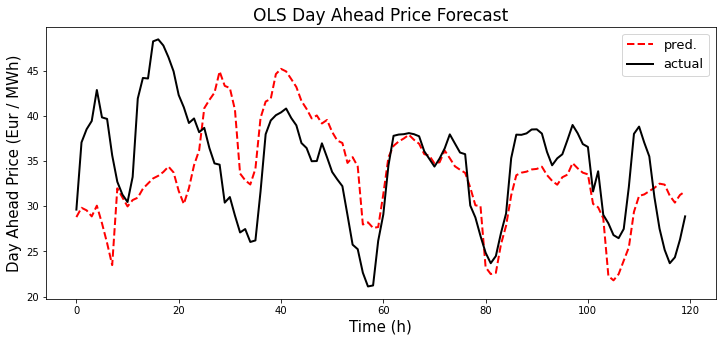

RMSE: 13.743685711403927
MAPE: inf


In [13]:
# Day ahead price prediction 
y_pred_price_ols = model_prediction(linear_model.LinearRegression(), 
                                    X_train_price, 
                                    y_train_price, 
                                    X_test_price)

plot_prediction(y_pred_price_ols[:120], 
                y_test_price[:120], "Time (h)", 
                "Day Ahead Price (Eur / MWh)", 
                "OLS Day Ahead Price Forecast", 
                "ols_price_pred.png")

evaluation(y_test_price, y_pred_price_ols)

## 2.5 Export latex tables

In [14]:
#export ols results as latex tables
from stargazer.stargazer import Stargazer

est = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()
est2 = sm.OLS(endog=y_price, exog=sm.add_constant(X_price)).fit()

stargazer = Stargazer([est, est2])
stargazer.render_latex()
stargazer.title('OLS Forecasts')


beginningtex = """\\documentclass{report}
\\usepackage{booktabs}
\\begin{document}"""
endtex = "\end{document}"

f = open('OLStabledemand.tex', 'w')
f.write(beginningtex)
f.write(stargazer.render_latex())
f.write(endtex)
f.close()